In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Contents of This Notebook

1. [Analyzing the Data](#1)
1. [Data Visualization](#2)
1. [Data Preprocessing](#3)
1. [Model Configuration and The Results](#4)

<a id='1'></a>
# 1. Analyzing the Data

In [2]:
data = pd.read_csv("../input/room-occupancy-estimation-data-set/Occupancy_Estimation.csv")
data.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


Some columns seem to be not beneficial for final estimation. First let's get rid of them.

In [3]:
data.columns

Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count'],
      dtype='object')

In [4]:
cols_to_use = ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2','S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count']

data = data[cols_to_use]

In [5]:
data.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0,0,1
1,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0,0,1
2,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0,0,1
3,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0,0,1
4,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0,0,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   S1_Temp               10129 non-null  float64
 1   S2_Temp               10129 non-null  float64
 2   S3_Temp               10129 non-null  float64
 3   S4_Temp               10129 non-null  float64
 4   S1_Light              10129 non-null  int64  
 5   S2_Light              10129 non-null  int64  
 6   S3_Light              10129 non-null  int64  
 7   S4_Light              10129 non-null  int64  
 8   S1_Sound              10129 non-null  float64
 9   S2_Sound              10129 non-null  float64
 10  S3_Sound              10129 non-null  float64
 11  S4_Sound              10129 non-null  float64
 12  S5_CO2                10129 non-null  int64  
 13  S6_PIR                10129 non-null  int64  
 14  S7_PIR                10129 non-null  int64  
 15  Room_Occupancy_Coun

We have a full dataset.

In [7]:
y = data['Room_Occupancy_Count']
X = data.drop('Room_Occupancy_Count', axis = 1)

In [8]:
X.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S6_PIR,S7_PIR
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,0.090137,0.079574
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,0.286392,0.270645
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,1.000000,1.000000


From this tabulated data we can realize the following,
1. Distribution of features varies a lot.
2. Range of some columns is considerably different than the others.

<a id='2'></a>
# 2. Data Visualization

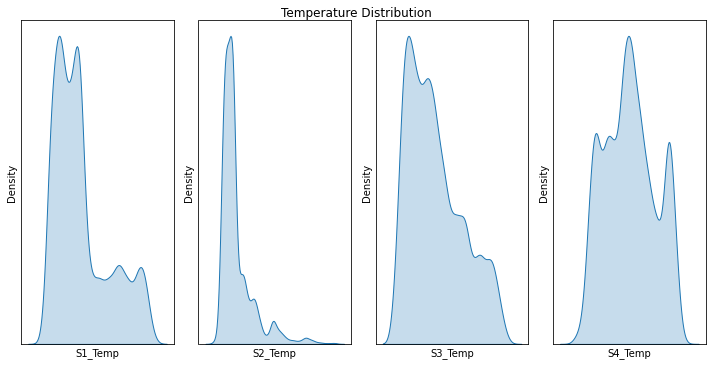

In [9]:
fig, ax = plt.subplots(1,4, figsize = (10,5))

ax = ax.flatten()

for index, axis in enumerate(ax):
    axis = sns.kdeplot(data = X,
               ax = axis,
               x = f"S{index + 1}_Temp",
               fill = True
               )
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(f"S{index + 1}_Temp")
fig.tight_layout()
plt.suptitle("Temperature Distribution",va = 'baseline')
plt.show()
    
    

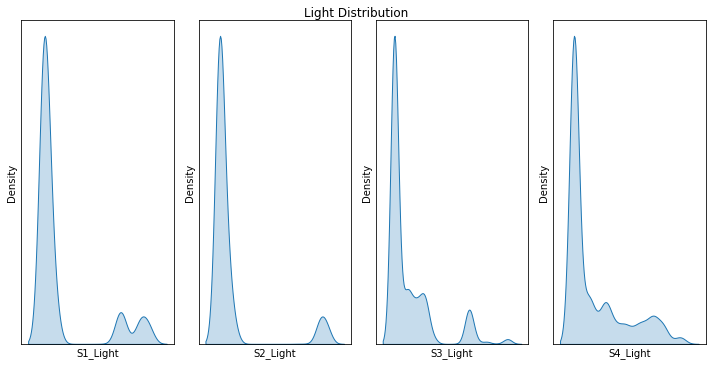

In [10]:
fig, ax = plt.subplots(1,4, figsize = (10,5))

ax = ax.flatten()

for index, axis in enumerate(ax):
    axis = sns.kdeplot(data = X,
               ax = axis,
               x = f"S{index + 1}_Light",
               fill = True
               )
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(f"S{index + 1}_Light")
fig.tight_layout()
plt.suptitle("Light Distribution",va = 'baseline')
plt.show()

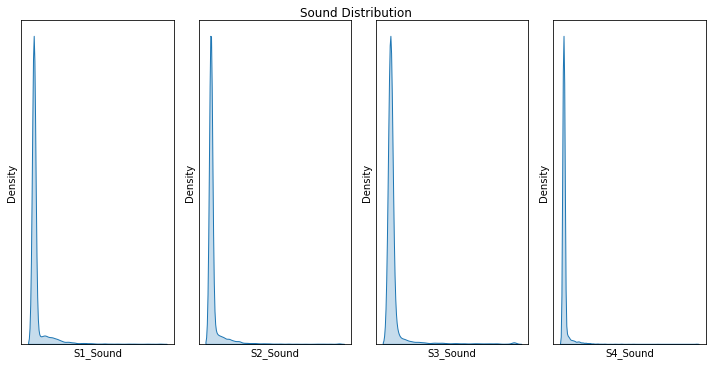

In [11]:
fig, ax = plt.subplots(1,4, figsize = (10,5))

ax = ax.flatten()

for index, axis in enumerate(ax):
    axis = sns.kdeplot(data = X,
               ax = axis,
               x = f"S{index + 1}_Sound",
               fill = True
               )
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(f"S{index + 1}_Sound")
fig.tight_layout()
plt.suptitle("Sound Distribution",va = 'baseline')
plt.show()
    

In general, the data is positively skewed.

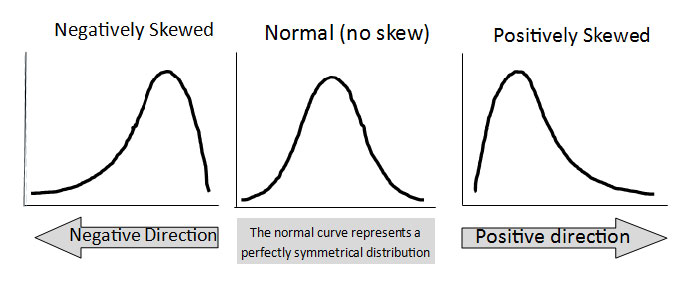 

[(Reference for the photo)](https://www.managedfuturesinvesting.com/images/default-source/default-album/measure-of-skewness.jpg?sfvrsn=0)

And finally for this section, of course, we have the heatmap (or in this case the cluster map). 

<Figure size 720x720 with 0 Axes>

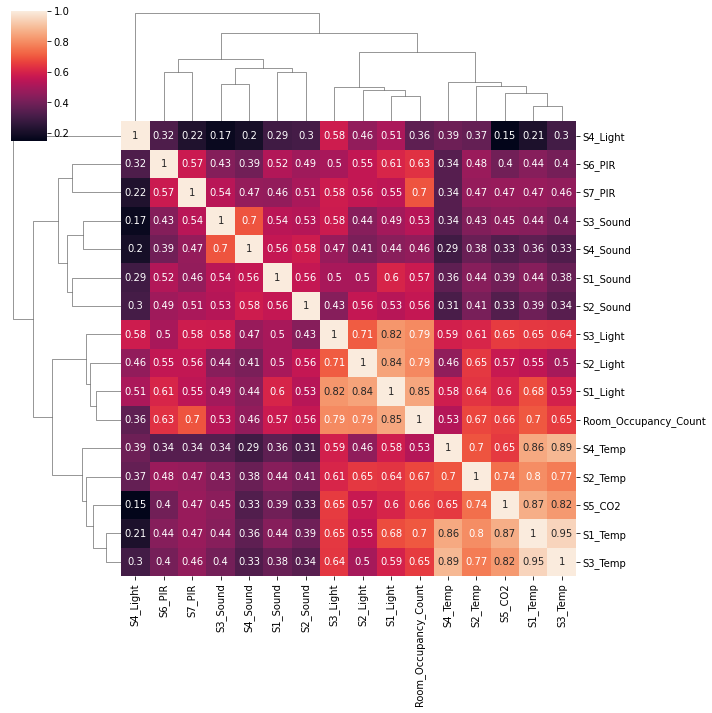

In [12]:
plt.figure(figsize = (10,10))
sns.clustermap(data.corr(), annot = True)

<a id='3'></a>
# 3. Data Preprocessing

So far we analyzed the data and we plot some graphs to understand it even further. Let's take some action accordingly and serve a better dataset to our Deep Learning model.

In [13]:
def normalization(df):
  for i in df.columns:
    upper_bound = df[i].max()
    lower_bound = df[i].min()
    df[i] = (df[i]-lower_bound)/(upper_bound-lower_bound)
  return df

X_norm = normalization(X)


In [14]:
X["TempSum"] = X.iloc[:,:3].sum(axis = 1)
X["TempMin"] = X.iloc[:,:3].min(axis = 1)
X["TempMax"] = X.iloc[:,:3].max(axis = 1)
X["TempAvg"] = X.iloc[:,:3].mean(axis = 1)
X["LightSum"] = X.iloc[:,4:8].sum(axis = 1)
X["LightMin"] = X.iloc[:,4:8].min(axis = 1)
X["LightMax"] = X.iloc[:,4:8].max(axis = 1)
X["LightAvg"] = X.iloc[:,4:8].mean(axis = 1)
X["SoundSum"] = X.iloc[:,8:12].sum(axis = 1)
X["SoundMin"] = X.iloc[:,8:12].min(axis = 1)
X["SoundMax"] = X.iloc[:,8:12].max(axis = 1)
X["SoundAvg"] = X.iloc[:,8:12].mean(axis = 1)

In [15]:
def normalization(df):
  for i in df.columns:
    upper_bound = df[i].max()
    lower_bound = df[i].min()
    df[i] = (df[i]-lower_bound)/(upper_bound-lower_bound)
  return df

X_norm = normalization(X)

In [16]:
y = to_categorical(y)

<a id='4'></a>
# 4. Model Configuration and The Results

In [17]:
model = Sequential([
                    Dense(200, activation = "swish", input_shape = (X.shape[1],)),
                    Dropout(0.5),
                    Dense(100, activation = "swish"),
                    Dropout(0.5),
                    Dense(50,activation = "swish"),
                    Dropout(0.5),
                    Dense(4, activation = "softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               5600      
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [18]:
model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = AUC())

history = model.fit(X_norm,y, validation_split = 0.2,
                     callbacks = [EarlyStopping(patience = 30),ReduceLROnPlateau(factor = 0.05, patience = 10, mode = "max")],
                     epochs = 100)

2022-01-03 03:45:01.202701: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
254/254 [==============================] - 3s 6ms/step - loss: 0.3702 - auc: 0.9800 - val_loss: 0.5879 - val_auc: 0.9539
Epoch 2/100
254/254 [==============================] - 1s 4ms/step - loss: 0.0911 - auc: 0.9978 - val_loss: 0.5971 - val_auc: 0.9642
Epoch 3/100
254/254 [==============================] - 1s 4ms/step - loss: 0.0577 - auc: 0.9981 - val_loss: 0.4758 - val_auc: 0.9839
Epoch 4/100
254/254 [==============================] - 1s 4ms/step - loss: 0.0479 - auc: 0.9984 - val_loss: 0.5821 - val_auc: 0.9702
Epoch 5/100
254/254 [==============================] - 1s 5ms/step - loss: 0.0414 - auc: 0.9985 - val_loss: 0.5358 - val_auc: 0.9742
Epoch 6/100
254/254 [==============================] - 1s 4ms/step - loss: 0.0406 - auc: 0.9985 - val_loss: 0.4477 - val_auc: 0.9853
Epoch 7/100
254/254 [==============================] - 1s 4ms/step - loss: 0.0364 - auc: 0.9990 - val_loss: 0.3914 - val_auc: 0.9885
Epoch 8/100
254/254 [==============================] - 1s 4ms/step - 

Thanks...